# Лабораторная работа 6. Рекуррентные сети

В работе демонстрируется построение рекуррентной нейронной сети для посимвольной генерации текста.  

Полезные ссылки:
- [Andrej Karpathy – The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness)
- [Practical PyTorch: Generating Shakespeare with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)
- [С. Николенко и др., 2018] – параграф 6.6.

In [1]:
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt

Задаем параметры:

In [2]:
filename = 'onegin.txt'  # Входной файл с текстом

seq_len = 200            # Размер последовательности для одной эпохи
batch_size_train = 1     # Размер батча для обучения
batch_size_test = 1      # Размер батча для предсказания (в данном случае всегда 1)
hidden_size = 100        # Размер скрытого состояния
embedding_size = 100     # Размер векторов-эмбеддингов для представления символов
num_layers = 1           # Количество слоев
lr = 0.005               # Скорость обучения
n_epochs = 1000          # Количество эпох
print_every = 100        # Интервал эпох для вывода результатов
plot_every = 10          # Интервал эпох для вывода потерь
predict_len = 100        # Количество символов для генерации

*Замечание*. Понятие "эпоха" обозначает период обработки всего обучающего множества. Но в контексте рекуррентных сетей это понятие может иметь значение, отличающееся от обычного, поскольку часто датасет бывает жестко не определен (например, из одного текста мы можем генерировать бесконечное количество последовательностей).  
Поэтому в данной лабораторной работе понятие "эпоха" обозначает период обработки всей последовательности размером `seq_len`.

Обеспечиваем воспроизводимость результатов (https://pytorch.org/docs/stable/notes/randomness.html):

In [3]:
torch.manual_seed(0)

---
Подготовьте входной текстовый файл. Можно взять ваше любимое художественное произведение.  
Здесь в качестве примера используется "Евгений Онегин".

In [4]:
with open(filename, encoding='utf-8') as f:
    data = f.read()
print(f'Длина текста: {len(data)} символов')
print(f'\nПервые {seq_len} строк:\n\n{data[:seq_len]}')

Длина текста: 144313 символов

Первые 200 строк:

ЕВГЕНИЙ ОНЕГИН

РОМАН В СТИХАХ

Petri  de  vanite  il  avait  encore plus de cette espece d'orgueil qui fait
avouer  avec  la  meme  indifference les bonnes comme les mauvaises actions,
suite d'un sen


---
Переводим текст в нижний регистр и создаем словарь всех символов:

In [5]:
data = data.lower()

vocabulary = set(data)
vocabulary = sorted(vocabulary)
print(f'Размер словаря: {len(vocabulary)}')
print(vocabulary)

Размер словаря: 82
['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']


---
Подготовим функцию для генерации случайных последовательностей длиной `seq_len+1` из входного текста.  
Единица прибавляется, так как в дальнейшем мы будем из этой сгенерированной последовательности получать две:
- *обучающую*, без последнего символа,
- *предсказываемую*, без первого символа.  

Таким образом, предсказываемая последовательность будет как бы сдвинута относительно обучающей на единицу вправо и каждый символ предсказываемой последовательности будет являться следующим символом для соответствующего обучающего символа.  
Обе последовательности будут на единицу меньше исходной последовательности.

In [6]:
def random_sequence(data, seq_len):
    start_index = random.randint(0, len(data) - seq_len - 1)
    end_index = start_index + seq_len + 1
    return data[start_index:end_index]

sequence = random_sequence(data, seq_len)
print(f'length = {len(sequence)}\n\n{sequence}')

length = 201

а!
как утеснительного сана
приемы скоро приняла!
кто б смел искать девчонки нежной
в сей величавой, в сей небрежной
законодательнице зал?
и он ей сердце волновал!
об нем она во мраке ночи,
пока морфей 


---
Задаем модель:

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers=1):
        
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size)
        self.rnn = nn.RNN(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers)
        self.decoder = nn.Linear(in_features=hidden_size, out_features=output_size)
    
    def forward(self, input, hidden):
        # На вход поступает двумерный тензор индексов символов размерности (seq_len, batch_size)
        embeddings = self.embedding(input)
        
        # После слоя Embedding добавляется ещё одна размерность (векторов-эмбеддингов для индексов символов).
        # Итоговая размерность входа для RNN будет (seq_len, batch_size, embedding_size)
        output, hidden = self.rnn(embeddings, hidden)
        
        # Преобразуем скрытое состояние RNN для каждого символа в вероятности следующего символа.
        output = self.decoder(output)
        
        # Размерность выхода: (seq_len, batch_size, output_size=len(vocabulary))
        return output, hidden

    def init_hidden(self, batch_size):
        # Должна быть размерность (num_layers * num_directions, batch_size, hidden_size)
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

Класс `Embedding` используется для формирования векторного представления каких-либо элементов (символов, слов, изображений, звуков и т.п.). Он представляет собой таблицу поиска (lookup table), на вход которой поступают индексы элементов, а на выходе выдаются векторные представления этих элементов ([справка PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)).  
Слой `Embedding` имеет свою матрицу весов, которые настраиваются в процессе обучения. Веса инициализируются из нормального распределения $N(0,1)$.  
После обучения слой `Embedding` будет содержать веса, в каком-то смысле "хорошо" представляющие входные элементы для текущей задачи.  
Данный слой при создании требует двух основных параметров:
- `num_embeddings` – размер словаря элементов (общее количество элементов, которые мы хотим закодировать);
- `embedding_dim` – размерность выходных векторов.  

Слой `Embedding` является, по сути, аналогом обычного слоя `Linear`, но `Linear` на входе ожидает вектор (например, *one-hot encoding* представление элементов), а на входе `Embedding` – тензоры любой размерности, содержащие просто индексы элементов, для которых необходимо получить векторное представление:

In [8]:
# Пример
embedding = nn.Embedding(num_embeddings=10, embedding_dim=3)
print(f'embedding.weight:\n{embedding.weight.data}')

i = torch.tensor(5)
print(f'\nВектор для элемента с индексом {i}:\n{embedding(i).data}')

array = torch.tensor([[1, 2], [4, 5]])
print(f'\nВекторы для массива индексов:\n{embedding(array).data}')

embedding.weight:
tensor([[-1.1258, -1.1524, -0.2506],
        [-0.4339,  0.8487,  0.6920],
        [-0.3160, -2.1152,  0.3223],
        [-1.2633,  0.3500,  0.3081],
        [ 0.1198,  1.2377, -0.1435],
        [-0.1116, -0.6136,  0.0316],
        [-0.4927,  0.2484,  0.4397],
        [ 0.1124, -0.8411, -2.3160],
        [-0.1023,  0.7924, -0.2897],
        [ 0.0525,  0.5229,  2.3022]])

Вектор для элемента с индексом 5:
tensor([-0.1116, -0.6136,  0.0316])

Векторы для массива индексов:
tensor([[[-0.4339,  0.8487,  0.6920],
         [-0.3160, -2.1152,  0.3223]],

        [[ 0.1198,  1.2377, -0.1435],
         [-0.1116, -0.6136,  0.0316]]])


---
В итоге, модель будет выглядеть следующим образом:  

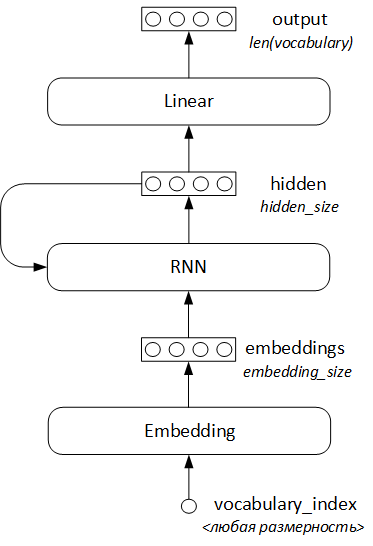

---
Функция, которая по входной строке возвращает список индексов из словаря `vocabulary`:

In [9]:
def char_to_tensor(string, vocabulary):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = vocabulary.index(string[c])
    return tensor

indices = char_to_tensor('онегин', vocabulary)
print(indices)

tensor([64, 63, 55, 53, 58, 63])


Напишем также функцию для обратного преобразования из списка индексов в строку:

In [10]:
def tensor_to_char(tensor, vocabulary):
    s = ''
    for t in tensor:
        s += vocabulary[int(t)]
    return s

print(tensor_to_char(indices, vocabulary))

онегин


---
Напишем функцию для генерации пары (входная последовательность, выходная последовательность).  
В качестве входной (обучающей) последовательности выступает случайная строка без последнего символа;  
выходная последовательность – та же строка без первого символа.  
Таким образом, каждому элементу входной последовательности (символу) соответствует элемент выходной последовательности (символ), который является следующим символом в строке.  
Выходная последовательность является целевой переменной, именно её сеть будет пытаться предсказать.  
Размер каждой последовательности – `seq_len`.

In [11]:
def random_training_set(data, seq_len, vocabulary):
    sequence = random_sequence(data, seq_len)
    input = char_to_tensor(sequence[:-1], vocabulary)
    target = char_to_tensor(sequence[1:], vocabulary)
    return input, target

In [12]:
input, target = random_training_set(data, seq_len, vocabulary)

print(f'********** input ({len(input)})**********\n\n{input.data}')
print(f'\n********** target ({len(target)}) **********\n{target.data}')

********** input (200)**********

tensor([66, 55, 57, 63, 64, 59,  9,  0, 63, 64,  7,  1, 54, 52, 55, 66, 78,  1,
        68, 58, 71, 64, 63, 78, 60, 64,  1, 64, 68, 65, 58, 66, 50, 81,  7,  0,
        69, 56,  1, 55, 59,  1, 70, 58, 61, 58, 65, 78, 55, 52, 63, 50,  1, 67,
        55, 54, 50, 81,  0, 65, 66, 58, 63, 64, 67, 58, 68,  1, 63, 50,  1, 65,
        64, 54, 63, 64, 67, 55,  1, 73, 50, 59,  9,  0,  3, 65, 64, 66, 50,  7,
         1, 54, 58, 68, 81,  1, 62, 64, 55,  7,  1, 52, 67, 68, 50, 52, 50, 59,
        20,  0, 54, 50,  1, 68, 77,  7,  1, 60, 66, 50, 67, 50, 52, 58, 72, 50,
         7,  1, 53, 64, 68, 64, 52, 50,  2,  0, 64,  1, 65, 68, 50, 74, 60, 50,
         1, 66, 50, 63, 63, 81, 81,  1, 62, 64, 81,  2,  0, 52, 55, 73, 64, 66,
         1, 69, 56,  1, 60, 50, 60,  1, 51, 64, 81, 61, 50, 67, 78,  1, 81,  2,
         0, 54, 50,  7,  1, 67, 61, 50, 52, 50,  1, 51, 64, 53, 69,  7,  1, 68,
        77,  1])

********** target (200) **********
tensor([55, 57, 63, 64, 59,  9,  

Преобразуем полученные тензоры в строки:

In [13]:
print(f'********** input **********\n\n{tensor_to_char(input, vocabulary)}')
print(f'\n********** target **********\n\n{tensor_to_char(target, vocabulary)}')

********** input **********

резной.
но, дверь тихонько отпирая,
уж ей филипьевна седая
приносит на подносе чай.
"пора, дитя мое, вставай:
да ты, красавица, готова!
о пташка ранняя моя!
вечор уж как боялась я!
да, слава богу, ты 

********** target **********

езной.
но, дверь тихонько отпирая,
уж ей филипьевна седая
приносит на подносе чай.
"пора, дитя мое, вставай:
да ты, красавица, готова!
о пташка ранняя моя!
вечор уж как боялась я!
да, слава богу, ты з


---
RNN требует на вход трехмерный тензор размерностью: `(seq_len, batch_size, input_size)`:
\
\
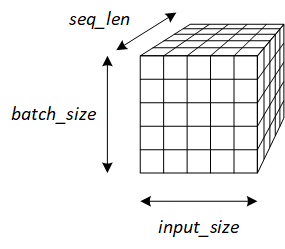


Таким образом, последовательности символов будут располагаться вдоль размерности `seq_len`.

Этот трехмерный тензор подается на вход RNN по мини-батчам:
\
\
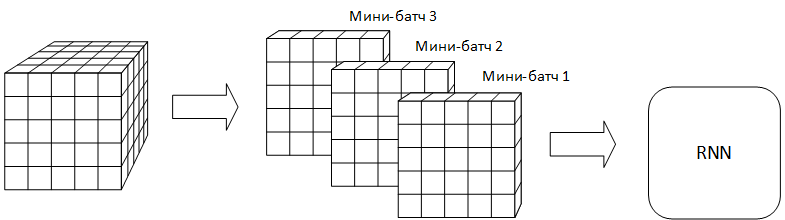

Каждый мини-батч обрабатывается в RNN одновременно; при этом формируется столько же скрытых состояний, сколько векторов в мини-батче. Эти скрытые состояния также являются выходами RNN: на каждый вектор мини-батча – свой выходной вектор (он же скрытое состояние).

В нашем примере:
- `input_size = 1` – на вход подается только индекс текущего символа в словаре, который в слое `Embedding` преобразуется в вектор размерности `embedding_size`;
- `batch_size = batch_size_train` – размер мини-батча;
- `seq_len = 200` – длина последовательности символов на одном шаге:
\
\
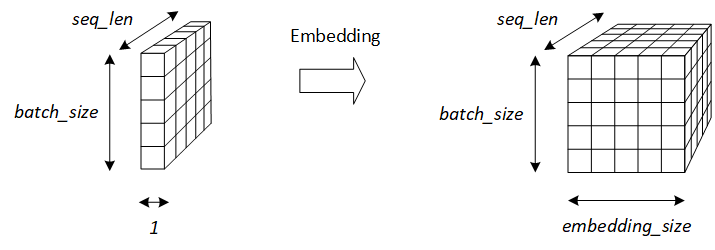

---
Зададим функцию обучения для одной эпохи – это процедура обработки в RNN всех мини-батчей, входящих в последовательность размером `seq_len`. Каждый мини-батч включает всего один индекс символа в словаре.  

Инициализация (обнуление) скрытого состояния происходит в начале каждого шага. Существует две стратегии инициализации скрытого состояния:
1. Если обрабатываются продолжительные непрерывные входные данные (например, "Война и мир"), разбитые на последовательности, и последовательность на текущем шаге является продолжением последовательности на предыдущем шаге, то скрытые состояния можно передавать с предыдущей эпохи (после обработки всей последовательности).
1. Если датасет состоит из отдельных последовательностей, не связанных между собой (например, твитов), то скрытое состояние желательно обнулять перед каждой эпохой.  

В нашем примере последовательности для каждой эпохи формируются независимо друг от друга, поэтому скрытые состояния обнуляются.

In [21]:
def train(input, target, batch_size):
    '''
    input - тензор размерности (seq_len, batch_size). Тензор содержит индексы символов.
    target - истинная последовательность индексов следующих символов (целевая переменная); размерность (seq_len, batch_size)
    '''
    
    # Инициализируем скрытое состояние
    hidden = rnn.init_hidden(batch_size=batch_size)
    
    rnn.zero_grad()
    loss = 0
    
    outputs, hidden = rnn(input, hidden)
    
    # Преобразуем размерности для вычисления функции потерь
    outputs = outputs.view(seq_len * batch_size, -1)
    target = target.view(seq_len * batch_size)
    
    loss = criterion(outputs, target)
    
    loss.backward()
    rnn_optimizer.step()

    return loss.data / len(input)

---
Операция `view` в PyTorch создает новый тензор как "представление" существущего тензора: сами данные никуда не копируются, но размерность данных меняется. Таким образом, экономятся память и время.

In [15]:
# Пример
t = torch.rand(2, 2)
print(f'Исходный тензор:\n{t}')

b = t.view(1, -1)
print(f'\nТензор-представление (view):\n{b}')

# Данные в обоих тензорах разделяются
print(f'\nДанные совпадают? - {t.untyped_storage().data_ptr() == b.untyped_storage().data_ptr()}')

# Изменение тензора-представления изменяет базовый тензор
b[0][1] = 1
print(f'\nИсходный тензор:\n{t}')

# Растягиваем двумерный тензор в одномерный
b = b.view(-1)
print(f'\nОдномерный тензор:\n{b}')

Исходный тензор:
tensor([[0.8155, 0.7932],
        [0.2783, 0.4820]])

Тензор-представление (view):
tensor([[0.8155, 0.7932, 0.2783, 0.4820]])

Данные совпадают? - True

Исходный тензор:
tensor([[0.8155, 1.0000],
        [0.2783, 0.4820]])

Одномерный тензор:
tensor([0.8155, 1.0000, 0.2783, 0.4820])


---
Напишем функцию, генерирующую текст длины `predict_len` с началом (префиксной строкой) `prefix`.  
Результирующая строка будет иметь вид: `prefix` + сгенерированная строка.

In [16]:
def evaluate(model, vocabulary, batch_size, prefix='а', predict_len=100):
    
    # Инициализируем скрытое состояние
    hidden = model.init_hidden(batch_size)
    
    # Преобразуем префиксную строку в тензор индексов
    prefix_input = char_to_tensor(prefix, vocabulary)
    
    # В переменной predicted будет храниться порождаемая строка (результат работы всей функции).
    # Записываем в неё сначала префиксную строку
    predicted = prefix

    # Запускаем модель на префиксной строке - формируем скрытое состояние для дальнейшей генерации
    for p in range(len(prefix) - 1):
        input = prefix_input[p]
        input = input.view(-1, 1)
        outputs, hidden = model(input, hidden)
    
    # В качестве первого символа для генерации (предсказания следующего символа) выступает последний символ префиксной строки
    input = prefix_input[-1]
    input = input.reshape(-1, 1)

    # Генерируем predict_len символов
    for p in range(predict_len):
        
        # Запускаем модель с текущим входным символом и текущим скрытым состоянием
        output, hidden = model(input, hidden)
        
        # В output возвращаются вероятности всех символов из словаря.
        # Выбираем из этого распределения символ (сэмплируем)
        output_dist = output.data.view(-1)
        output_dist = output_dist.exp()
        top_index = torch.multinomial(output_dist, 1)[0]
        
        # Добавляем предсказанный символ в результирующую строку
        predicted_char = vocabulary[top_index]
        predicted += predicted_char
        
        # Используем предсказанный символ как следующий вход
        input = char_to_tensor(predicted_char, vocabulary)
        input = input.reshape(-1, 1)

    return predicted

Вспомогательная функция для вывода времени:

In [17]:
def time_since(since):
    seconds = time.time() - since
    minutes = math.floor(seconds / 60)
    seconds -= minutes * 60
    return f'{minutes} min {seconds:.0f} sec'

---
Основная процедура обучения и генерации примеров текста в процессе обучения.  
Генерация текстов в ходе обучения необходима только для иллюстрации изменений возможностей модели по мере обучения.

In [18]:
# Создаем модель
rnn = RNN(
    input_size=len(vocabulary),
    embedding_size=embedding_size,
    hidden_size=hidden_size,
    output_size=len(vocabulary),
    num_layers=num_layers
)

rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()

prefix = 'а'         # Префиксная строка для генерации в процессе обучения. 

all_losses = []      # Список значений функции потерь в процессе обучения (для графика)
loss_avg = 0         # Усредненное по `plot_every` эпохам значение функции потерь для графика

for epoch in range(1, n_epochs + 1):
    
    # Генерируем первую последовательность
    input, target = random_training_set(data, seq_len, vocabulary)
    input = input.view(-1, 1)
    target = target.view(-1, 1)
    
    # Добавляем к первой последовательности другие в зависимости от количества мини-батчей
    for b in range(batch_size_train-1):
        sequence, target_seq = random_training_set(data, seq_len, vocabulary)
        sequence = sequence.view(-1, 1)
        target_seq = target_seq.view(-1, 1)
        input = torch.cat((input, sequence), dim=1)
        target = torch.cat((target, target_seq), dim=1)
    
    # Запускаем эпоху обучения
    loss = train(input, target, batch_size_train)
    loss_avg += loss

    # Осуществляем генерацию текста для текущей модели каждые `print_every` эпох
    if epoch % print_every == 0:
        
        print(f'[time = {time_since(start)}, epochs = {epoch} ({epoch / n_epochs * 100}%), loss = {loss:.4f}]')
        
        predicted_text = evaluate(
            model=rnn,
            vocabulary=vocabulary,
            batch_size=batch_size_test,
            prefix=prefix,
            predict_len=predict_len
        )
        print(predicted_text)
        print()

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[time = 0 min 2 sec, epochs = 100 (10.0%), loss = 0.0219]
ам,ы не советь ернот, приц бегодевы, о слежнек прадожал яень седетни; бонот сель нег..
вервать итруя 

[time = 0 min 3 sec, epochs = 200 (20.0%), loss = 0.0140]
азно люх иние в и гей,
онагко рам. вю блай,
е с тлаим,
воскис обал ем бела в граним семя вет; каматви

[time = 0 min 5 sec, epochs = 300 (30.0%), loss = 0.0118]
адевдей! - бестилонь, чие ластенивке, меегряшочук!нте раслят доги,
и на жабникно к.
iv

"воро в люй, 

[time = 0 min 8 sec, epochs = 400 (40.0%), loss = 0.0111]
а?
х заковой гречей, четань едей.
и шей н кнело,
и кризбеть потах семет
та,
ме греблеститей
наше полж

[time = 0 min 10 sec, epochs = 500 (50.0%), loss = 0.0117]
а, о с одлондей вдосвябри его деть,
ток точте,
делопетя рквы омогостраскрей.
аланяе....

превоведкилу

[time = 0 min 12 sec, epochs = 600 (60.0%), loss = 0.0114]
а бырят лел.
stere
токостел рамна не жедный в де как льбою посудашит,
бреесо попозрали
усты умогой ми

[time = 0 min 15 sec, epochs = 7

---
Рисуем график потерь:

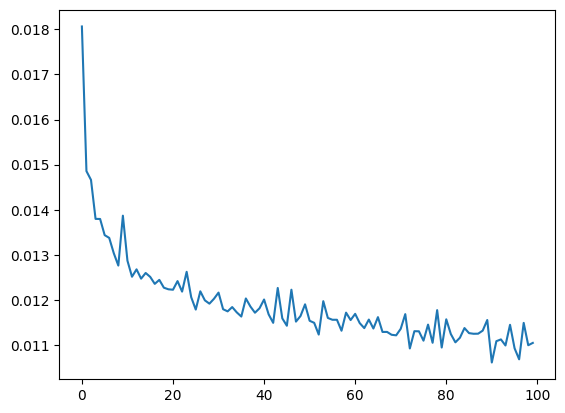

In [19]:
plt.figure()
plt.plot(all_losses)

После обучения можно подставить любое начало и сеть его продолжит:

In [20]:
beginning = 'мой дядя'

predict = evaluate(
    model=rnn,
    vocabulary=vocabulary,
    batch_size=batch_size_test,
    prefix=beginning,
    predict_len=predict_len
)

print(predict)

мой дядя злежмен,
исьза зде ним
преду стую не свитею
пред, и мой складий мал стви экоста;
но блестий
полою м


---
#### Задание 1.
Перенесите модель и данные на GPU.

#### Задание 2.
Запустите обучение модели с разным количеством эпох и размером мини-батча. Один или несколько результатов генерации в конце каждого эксперимента вместе с временем запуска и параметрами запишите в отдельный файл.  
Проведите не менее 10 экспериментов.  
Сделайте выводы об эффективности разных вариантов модели.

#### Задание 3.
Поменяйте модуль Simple RNN на LSTM. Запустите обучение модели с разным количеством эпох и размером мини-батча.  
Желательно, чтобы параметры совпадали с предыдущим экспериментом и можно было сравнивать модели.  
Один или несколько результатов генерации в конце каждого эксперимента вместе с временем запуска и параметрами запишите в отдельный файл.  
Проведите не менее 10 экспериментов.  
Сделайте выводы об эффективности разных вариантов модели.

#### Задание 4.
Повторите предыдущее задание для модуля GRU.  
Кроме выводов об эффективности, сделайте выводы о времени обучения разных моделей – Simple RNN, LSTM, GRU.

#### Задание 5.
Выберите лучшую модель по результатам предыдущих экспериментов и попробуйте добиться повышения качества за счёт разного количества слоёв.

#### Задание 6.
Прочитайте в [Николенко и др., 2018, стр. 266] о понятии "температура", которое часто используется при генерации текстов.  
Добавьте данный параметр в функцию `evaluate()`.  
Проверьте его влияние на результаты генерации.

#### Задание 7 (факультативное).
Разбейте текст на последовательности не случайным образом, а по предложениям.  
Предложения можно получить из текста при помощи функции `nltk.tokenize.sent_tokenize()`.  
Так как предложения окажутся неодинаковой длины, а последовательности на вход модели должны поступать одинакового размера, придется дополнить предложения до максимальной длины символом, не входящим в словарь (например, каким-нибудь из [управляющих символов](https://ru.wikipedia.org/wiki/Управляющие_символы) `\0`, `\a`, `\b` и т.д.).

#### Задание 8 (факультативное).
Реализуйте стратегию 3 из учебника [Николенко и др., 2018, стр. 260] – разбиение текста на последовательности примерно одной длины с правильно инициализированными скрытыми состояниями рекуррентной сети.